In [44]:
import sys
sys.path.append('../')  

from custom_loss_functions import psnr

from tensorflow.keras.models import load_model
from hformer_model import get_hformer_model, PatchExtractor

from skimage.util import view_as_blocks

import numpy as np

from skimage.metrics import peak_signal_noise_ratio

import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras import backend as K

from sklearn.model_selection import train_test_split

from data_importer import load_testing_images
from data_importer import load_training_images

import matplotlib.pyplot as plt


In [45]:
# Common testing image pairs (used to evaluate all models)

noisy_images, ground_truth_images = load_training_images('../../../../../Dataset/LowDoseCTGrandChallenge/Training_Image_Data', load_limited_images=True, num_images_to_load=5)

patch_extractor = PatchExtractor(patch_size=64, stride=64, name="patch_extractor")
test_image_patches = patch_extractor(noisy_images)

loaded training images x and y of len :  5 5  respectively
type of train images x :  float64
range of values in train images :  0.0 0.9640522875816994
type of train images y :  float64


Code for evaluation of model(s)

In [46]:
def view_model_history(history, psnr_or_accuracy):
    # Visualize model history.
    print('history keys : ', history.keys())

    # Plot loss, accuracy, val_loss and val_accuracy

    # Get the number of epochs
    num_epochs = len(history['loss'])

    # Plot training and validation accuracy / PSNR values
    if psnr_or_accuracy == 'accuracy':
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(range(1, num_epochs + 1), history['accuracy'], label='Training Accuracy')
        plt.plot(range(1, num_epochs + 1), history['val_accuracy'], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
    elif psnr_or_accuracy == 'psnr':
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(range(1, num_epochs + 1), history['psnr'], label='Training psnr')
        plt.plot(range(1, num_epochs + 1), history['val_psnr'], label='Validation psnr')
        plt.title('Training and Validation Psnr')
        plt.xlabel('Epoch')
        plt.ylabel('Psnr')
        plt.legend()
        
    # Plot training and validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), history['loss'], label='Training Loss')
    plt.plot(range(1, num_epochs + 1), history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [47]:
def reconstruct_image_from_patches(patches, num_patches_per_row):
    patch_size = patches.shape[1]  # Assuming square patches
    num_patches = patches.shape[0]

    # Calculate the number of rows
    num_patches_per_col = num_patches // num_patches_per_row

    # Initialize an empty image to store the reconstructed result
    reconstructed_image = np.zeros((num_patches_per_col * patch_size, num_patches_per_row * patch_size))

    # Reshape the patches into a 2D array
    patches_2d = patches.reshape((num_patches_per_col, num_patches_per_row, patch_size, patch_size))

    # Reconstruct the image by placing each patch in its corresponding position
    for i in range(num_patches_per_col):
        for j in range(num_patches_per_row):
            reconstructed_image[i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size] = patches_2d[i, j]

    return np.expand_dims(reconstructed_image, axis=-1)



In [48]:
def calculate_psnr(original_image, reconstructed_image):
    psnr_value = peak_signal_noise_ratio(original_image, reconstructed_image)
    return psnr_value


In [49]:
def visualize_patches(patches, noisy_images,  ground_truth_images, num_images):
    num_patches_per_image = int(patches.shape[0] / num_images)

    print('patches per image : ', num_patches_per_image)

    for i in range(num_images):
        print('this image has start patches : ', i * num_patches_per_image)
        image_patches = patches[i * num_patches_per_image:i * num_patches_per_image + num_patches_per_image]

        fig, axes = plt.subplots(1, 4, figsize=(24, 24))
        axes = axes.flatten()
        
        reconstruct_image = reconstruct_image_from_patches(image_patches, 8)
        print('reconstruct_image shape : ', reconstruct_image.shape)
        print('noisy image shape : ', noisy_images[i].shape)
        
        axes[0].set_title('input image')
        axes[0].imshow(noisy_images[i], cmap='gray', vmin=0, vmax=1)
        axes[0].axis('off')
        
        axes[1].set_title('ground truth image')
        axes[1].imshow(ground_truth_images[i], cmap='gray', vmin=0, vmax=1)
        axes[1].axis('off')
        
        
        axes[2].set_title('model prediction')
        axes[2].imshow(reconstruct_image, cmap='gray', vmin=0, vmax=1)
        axes[2].axis('off')
        
        axes[3].set_title('removed noise')
        axes[3].imshow((noisy_images[i] - reconstruct_image), cmap='gray', vmin=0, vmax=1)
        axes[3].axis('off')
        
        print('PSNR of reconsturcted image : ', calculate_psnr(ground_truth_images[i], reconstruct_image))
        print('PSNR of noisy image : ', calculate_psnr(ground_truth_images[i], noisy_images[i]))

        plt.show()


In [50]:
def evaluate_model(model, history, name, psnr_or_accuracy):
    print('Training history of model : ', name)
    view_model_history(history, psnr_or_accuracy)
    
    print('Model prediction test')
    predictions = model.predict(test_image_patches)
    
    visualize_patches(predictions, noisy_images, ground_truth_images, len(noisy_images))
    
    print('\n\n\n\n\n')
    

Test with the 'Small' version of hformer (16 channels), ~61K learnable parameters

Model: "hformer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_projection_layer (In  multiple                  160       
 putProjectionLayer)                                             
                                                                 
 output_projection_layer (O  multiple                  145       
 utputProjectionLayer)                                           
                                                                 
 conv_net_block_1 (Convolut  multiple                  1376      
 ionBlock)                                                       
                                                                 
 conv_net_block_2 (Convolut  multiple                  1376      
 ionBlock)                                                       
                                                                 
 downsampling_layer_1 (Conv  multiple                

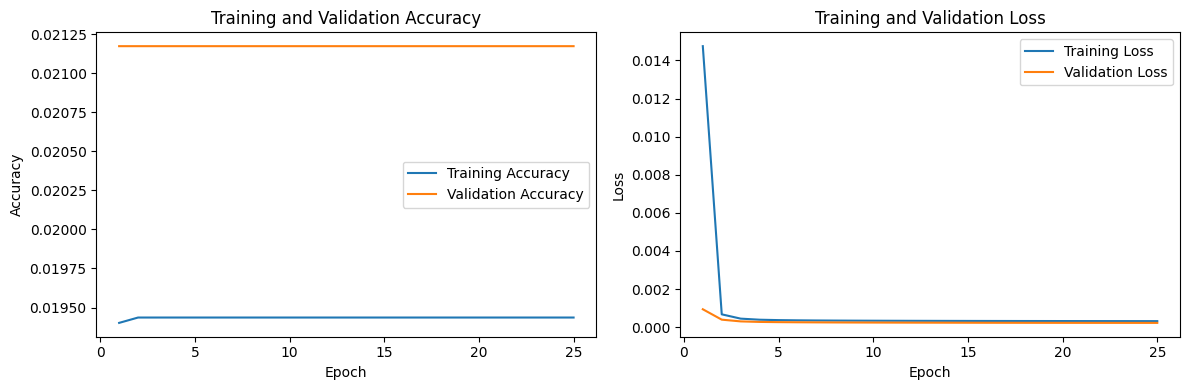

Model prediction test
10/10 [==============================] - 2s 96ms/step
patches per image :  64
this image has start patches :  0
reconstruct_image shape :  (512, 512, 1)
noisy image shape :  (512, 512, 1)
PSNR of reconsturcted image :  36.96806082502765
PSNR of noisy image :  35.42505782481389


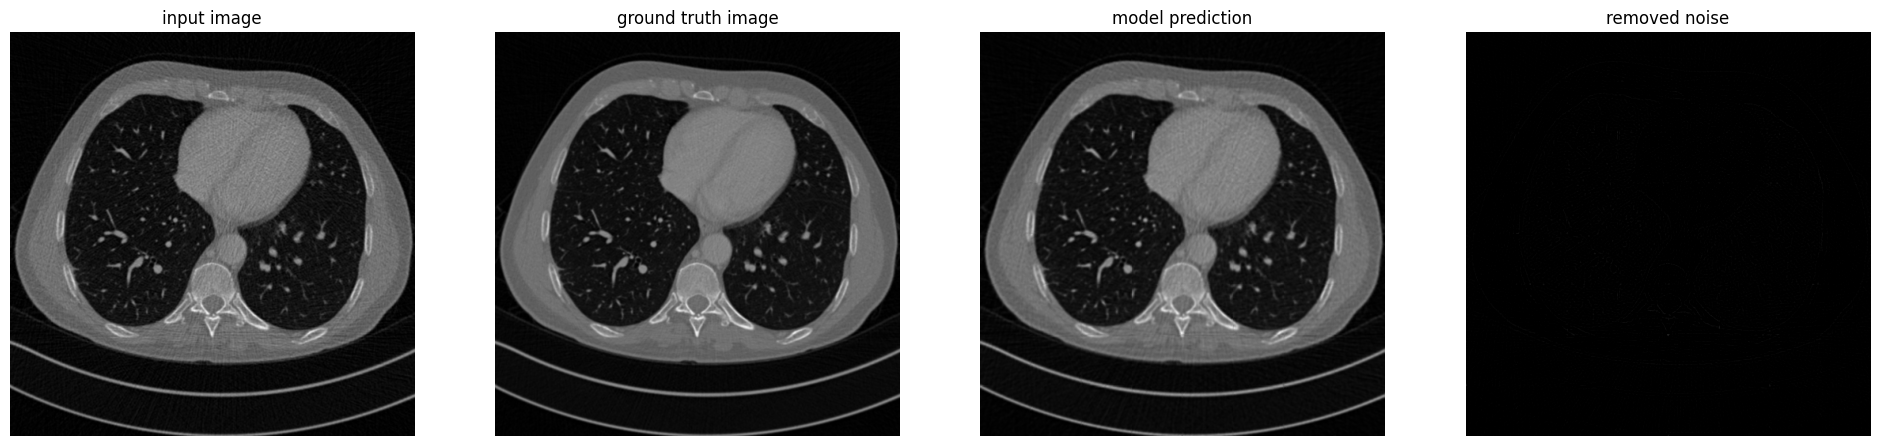

this image has start patches :  64
reconstruct_image shape :  (512, 512, 1)
noisy image shape :  (512, 512, 1)
PSNR of reconsturcted image :  37.18245272712009
PSNR of noisy image :  35.72104261508211


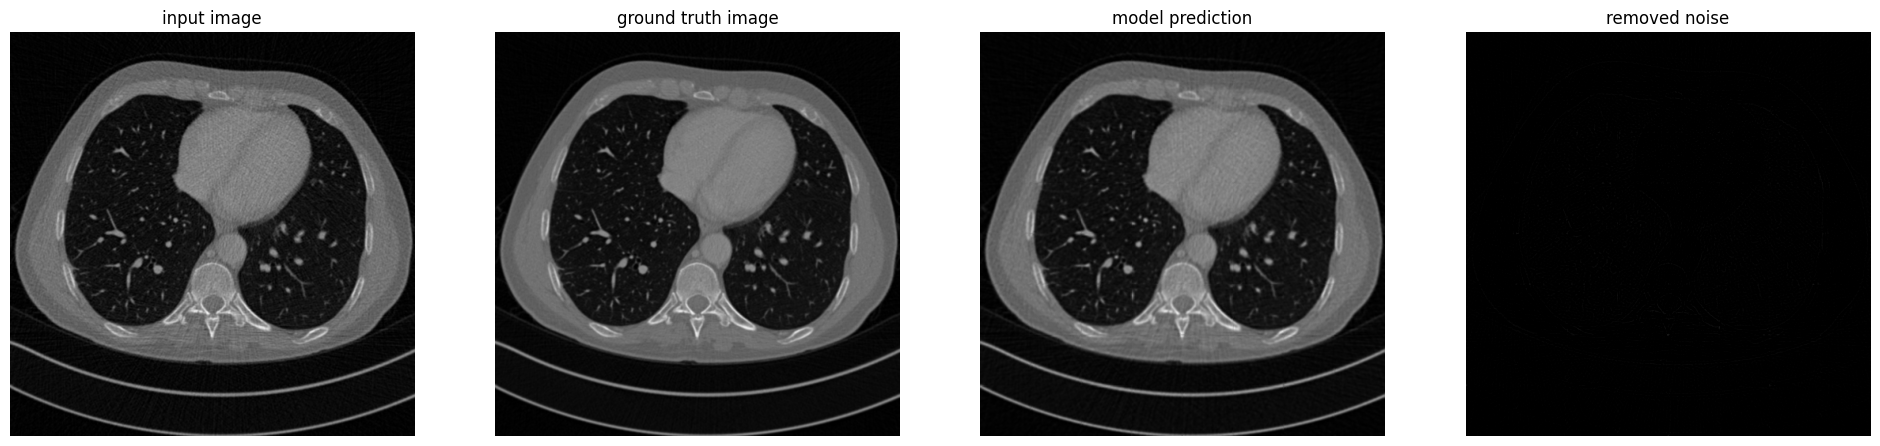

this image has start patches :  128
reconstruct_image shape :  (512, 512, 1)
noisy image shape :  (512, 512, 1)
PSNR of reconsturcted image :  37.251388393866264
PSNR of noisy image :  35.85128808487748


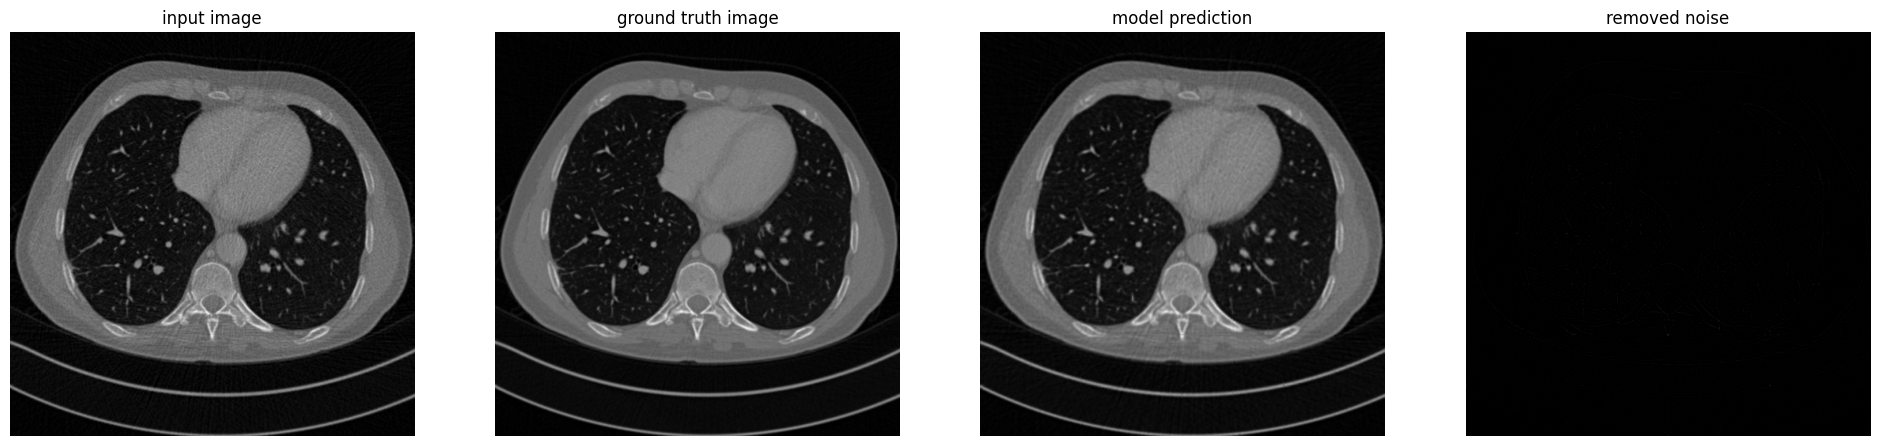

this image has start patches :  192
reconstruct_image shape :  (512, 512, 1)
noisy image shape :  (512, 512, 1)
PSNR of reconsturcted image :  37.16898677252717
PSNR of noisy image :  35.668860664970005


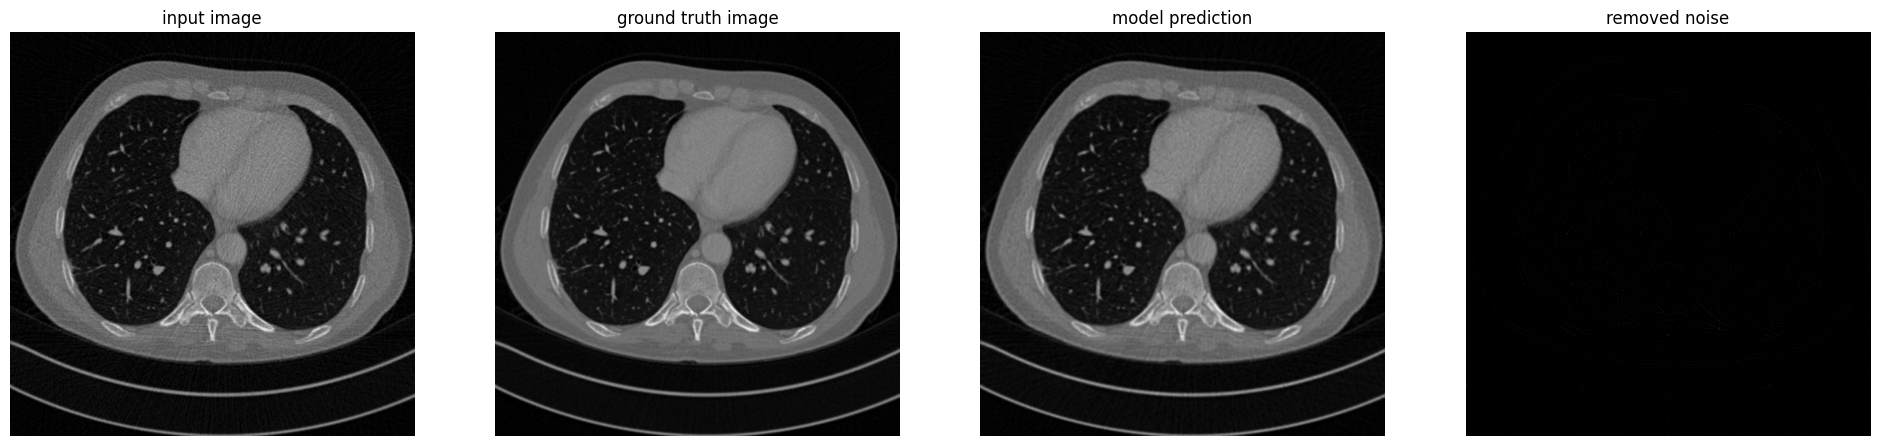

this image has start patches :  256
reconstruct_image shape :  (512, 512, 1)
noisy image shape :  (512, 512, 1)
PSNR of reconsturcted image :  37.393451893870804
PSNR of noisy image :  35.93805341002241


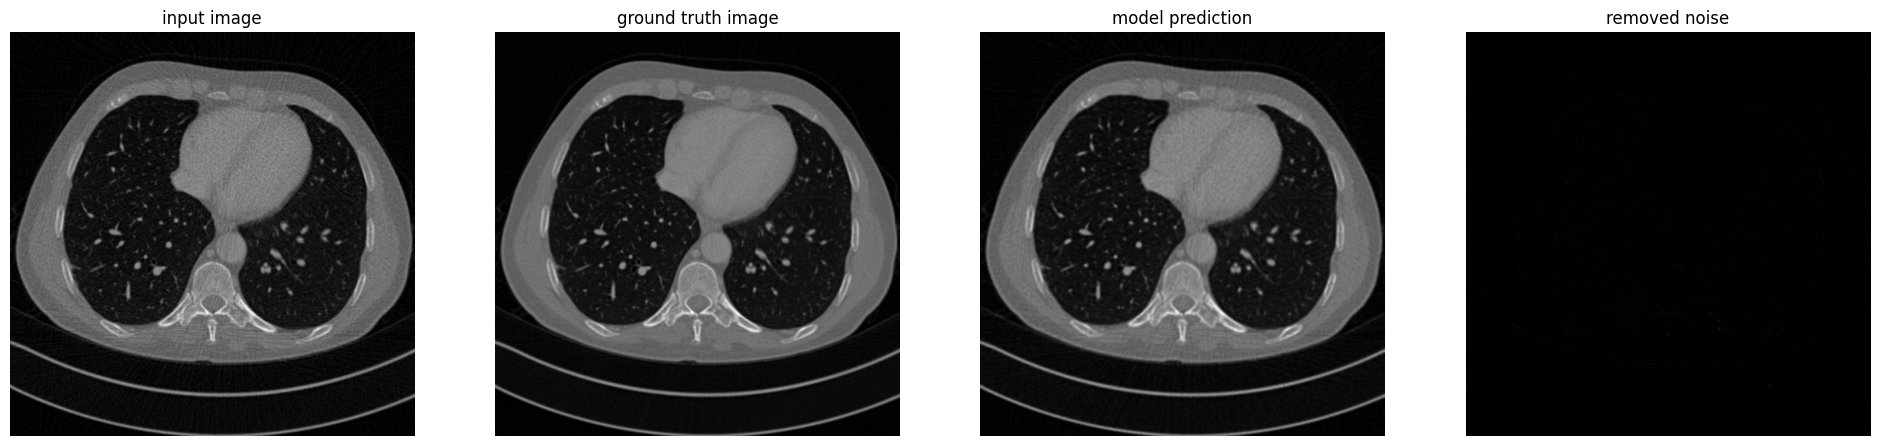

In [51]:
# Get model and build (required for loading weights).
from hformer_model import get_hformer_model

model = get_hformer_model(num_channels_to_be_generated=16, name="hformer_model")
model.build(input_shape=(None, 64, 64, 1)) 
model.summary()

# We are required to set custom_objects since we are using custom loss function
loaded_model = model.load_weights('hformer_25_epoch_16_channel_full_dataset.h5')
history = np.load('hformer_25_epoch_16_channel_full_datasethistory.npy', allow_pickle=True).item()

evaluate_model(model, history, 'hformer_16_channel_small', 'accuracy')

Evaluation of Hformer extended Medium (48 channel), ~850K learnable parameters

Model: "hformer_model_extended_48_channel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_projection_layer (In  multiple                  240       
 putProjectionLayer)                                             
                                                                 
 output_projection_layer (O  multiple                  193       
 utputProjectionLayer)                                           
                                                                 
 conv_net_block_1 (Convolut  multiple                  21168     
 ionBlock)                                                       
                                                                 
 conv_net_block_2 (Convolut  multiple                  21168     
 ionBlock)                                                       
                                                                 
 downsampling_layer_1 (Conv  mult

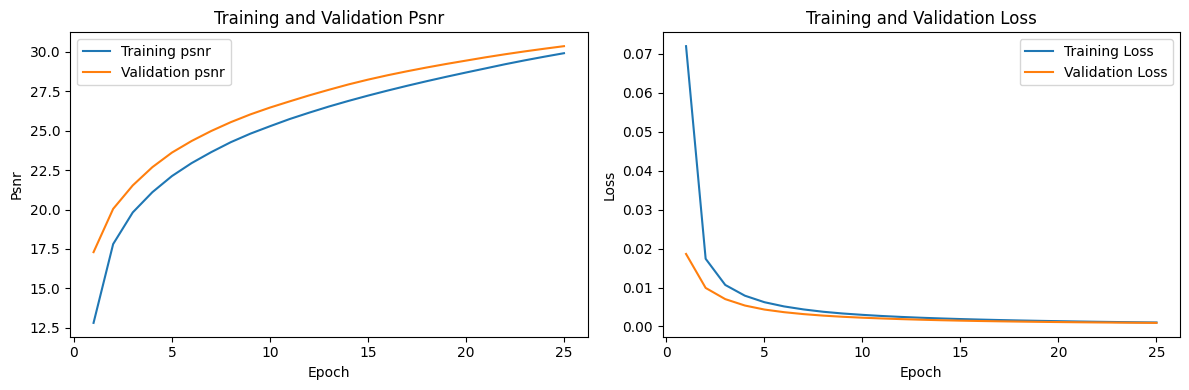

Model prediction test
10/10 [==============================] - 8s 649ms/step
patches per image :  64
this image has start patches :  0
reconstruct_image shape :  (512, 512, 1)
noisy image shape :  (512, 512, 1)
PSNR of reconsturcted image :  28.65094244432148
PSNR of noisy image :  35.42505782481389


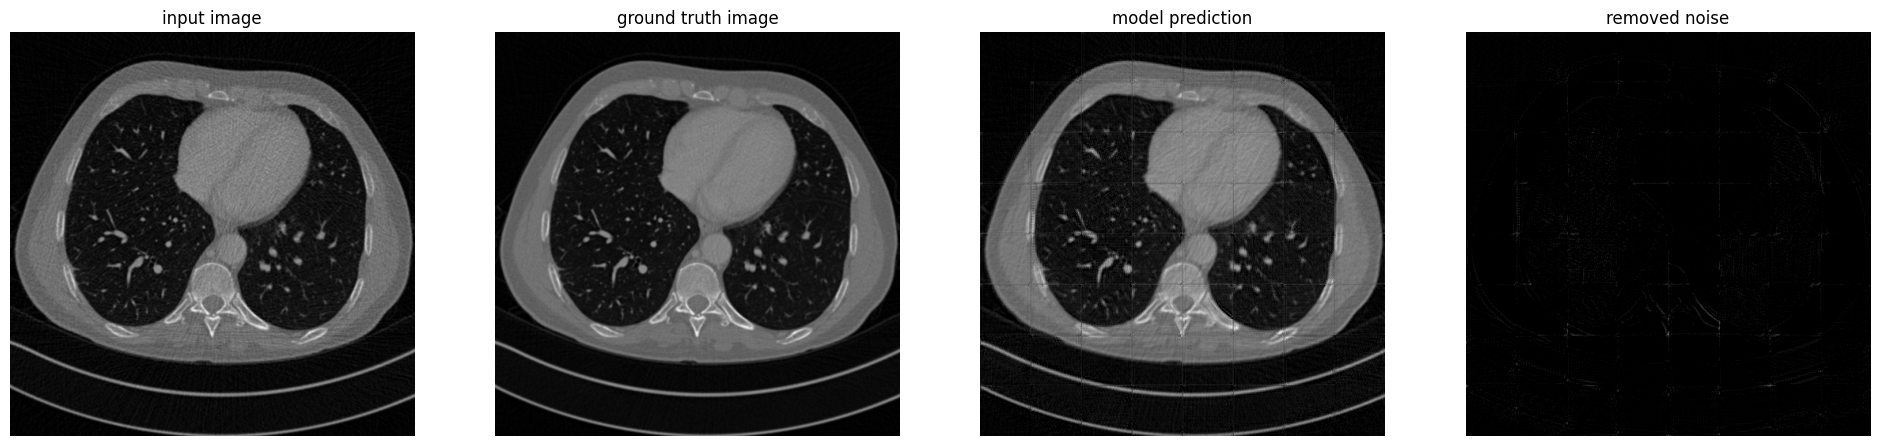

this image has start patches :  64
reconstruct_image shape :  (512, 512, 1)
noisy image shape :  (512, 512, 1)
PSNR of reconsturcted image :  28.730954524124165
PSNR of noisy image :  35.72104261508211


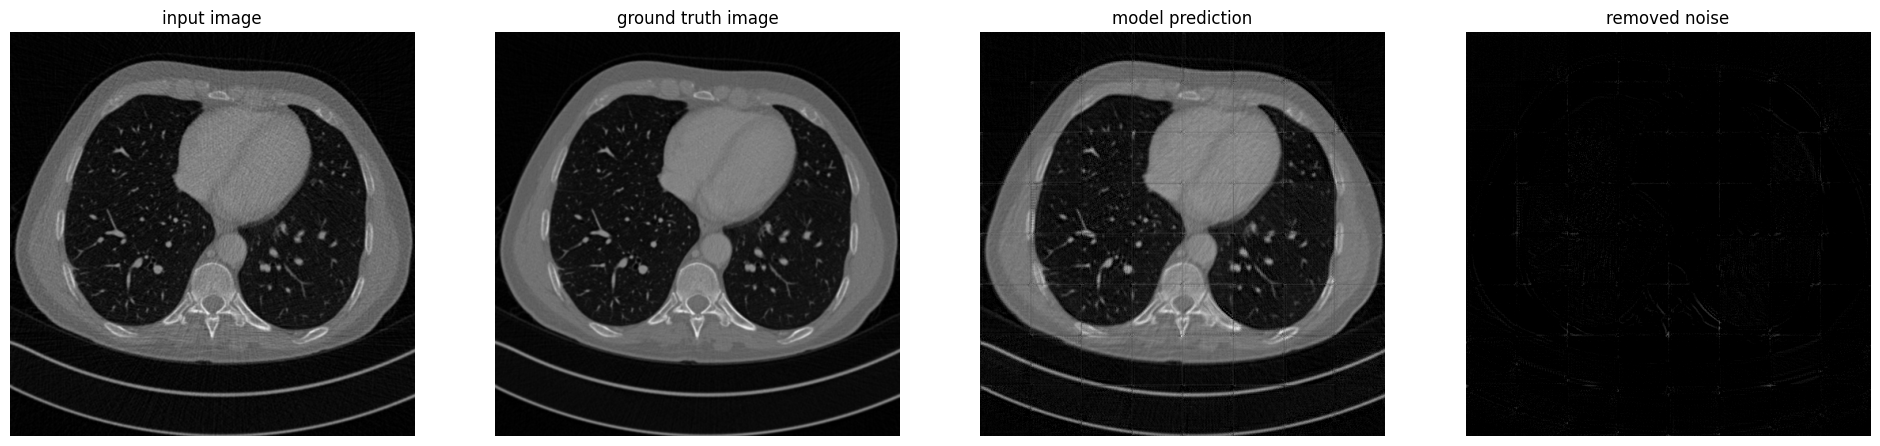

this image has start patches :  128
reconstruct_image shape :  (512, 512, 1)
noisy image shape :  (512, 512, 1)
PSNR of reconsturcted image :  28.752812049514922
PSNR of noisy image :  35.85128808487748


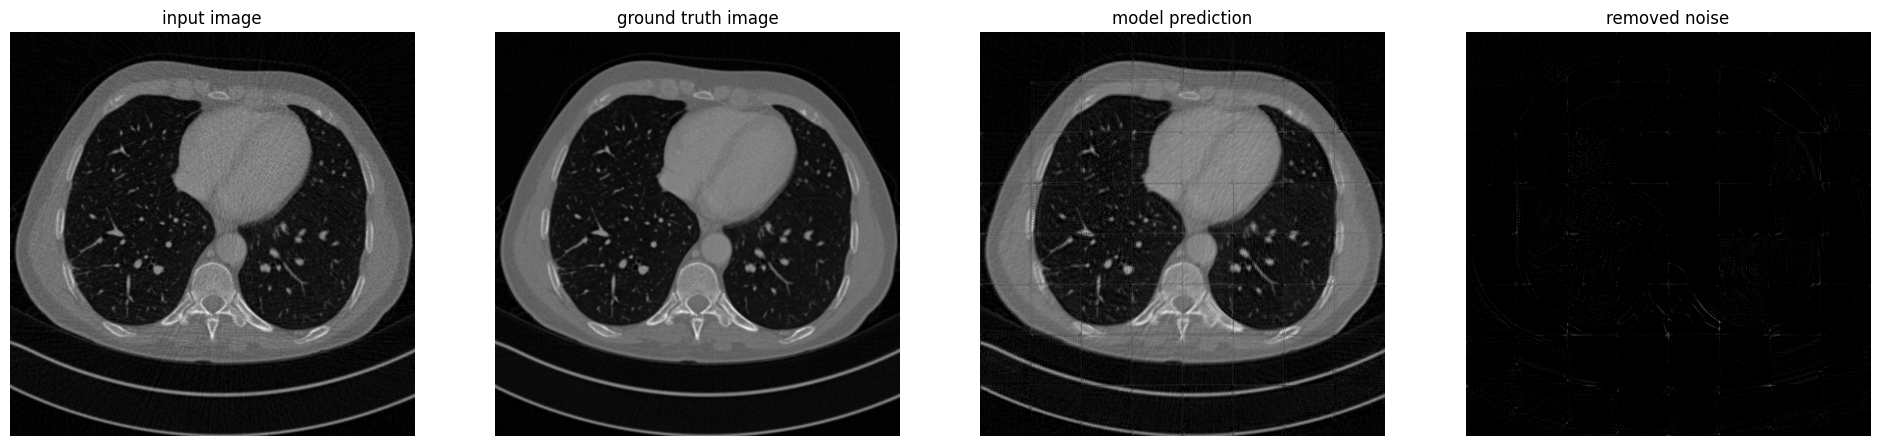

this image has start patches :  192
reconstruct_image shape :  (512, 512, 1)
noisy image shape :  (512, 512, 1)
PSNR of reconsturcted image :  28.723409256402526
PSNR of noisy image :  35.668860664970005


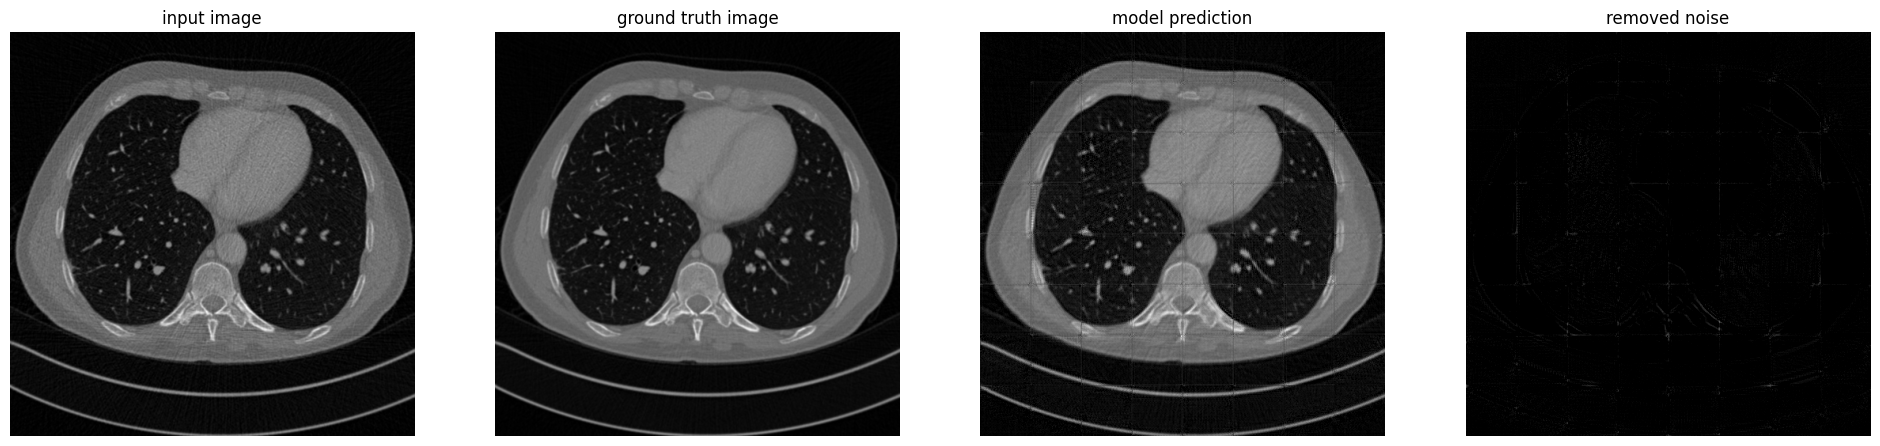

this image has start patches :  256
reconstruct_image shape :  (512, 512, 1)
noisy image shape :  (512, 512, 1)
PSNR of reconsturcted image :  28.83446590300848
PSNR of noisy image :  35.93805341002241


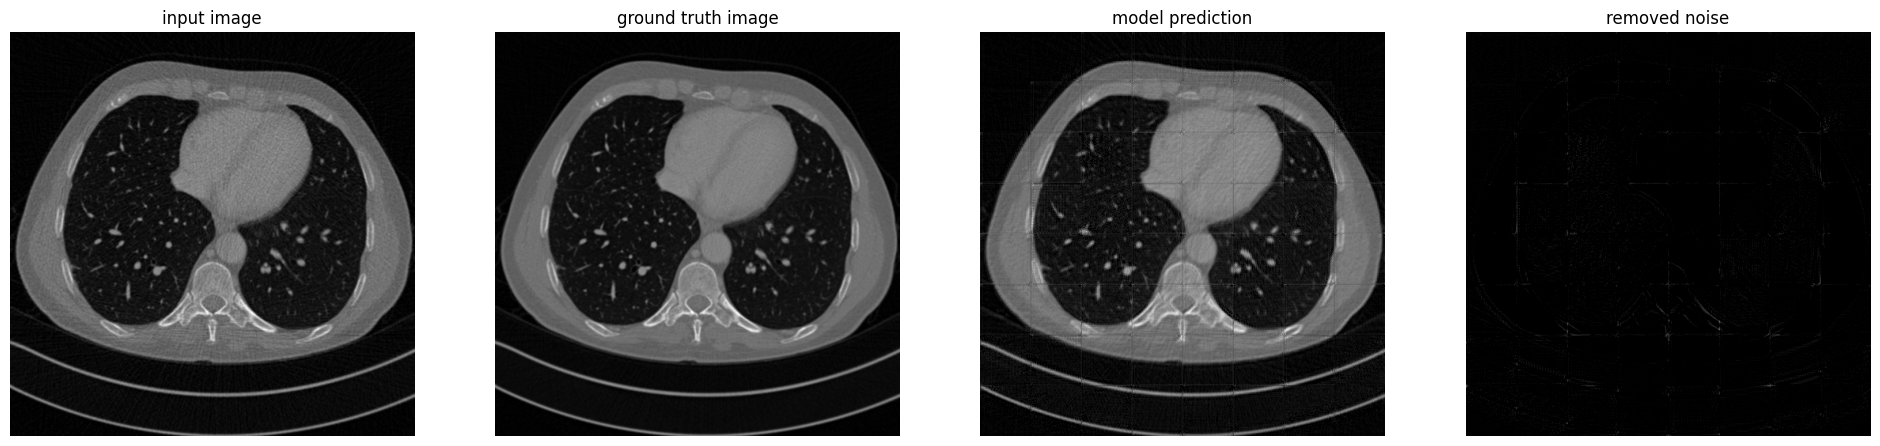

In [52]:
from hformer_model_extended import get_hformer_model

# Get model and build (required for loading weights).
model = get_hformer_model(num_channels_to_be_generated=48, name="hformer_model_extended_48_channel")
model.build(input_shape=(None, 64, 64, 1)) 
model.summary()

# We are required to set custom_objects since we are using custom loss function
loaded_model = model.load_weights('hformer_25_epoch_extended_48_channel.h5')
history = np.load('hformer_25_epoch_history_extended_48_channel.npy', allow_pickle=True).item()

evaluate_model(model, history, 'hformer_48_channel_medium_extended', 'psnr')